# Region spotting for B. Janz 🇨🇳 🤓 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import proplot as plot
import xarray as xr
import pandas as pd
import matplotlib
import matplotlib.patches as mpatches

In [3]:
regions = ['Naxi', 'Heijiang', 'Guanghan', 'Yanting County']

loc = {}
loc["Naxi"]     = (28.773333,105.371389)
loc["Heijiang"] = (28.783333,105.9)
loc["Guanghan"] = (30.99,104.25)
loc["Yanting County"] = (31.208,105.389)

# Data access


In [4]:
# GTOPO30 opendap url
da_gtopo30 = xr.open_dataset("https://pae-paha.pacioos.hawaii.edu/thredds/dodsC/srtm30plus_v11_land").elev

In [5]:
# WARNING coords are x/ y (y in reverse order)
da = xr.open_rasterio("data_china/Globcover2009_V2/GLOBCOVER_L4_200901_200912_V2.3.tif").squeeze(drop=True).sel(y=slice(35, 25), x=slice(100,110))
da.coords['lat'] = ('y',da.y)
da.coords['lon'] = ('x',da.x)
da_lu = da.swap_dims({'y':'lat','x':'lon'})
da_lu = da_lu.drop(['x','y'])
da_lu = da_lu.sortby('lat')
da_lu

<xarray.DataArray (lat: 3600, lon: 3600)>
array([[110,  20,  14, ...,  30,  30,  20],
       [110, 110,  14, ...,  30,  30,  30],
       [ 70, 100, 100, ...,  20,  30,  30],
       ...,
       [ 14,  14,  14, ...,  14,  14,  14],
       [ 14,  14,  14, ...,  14,  14,  14],
       [ 14,  14,  14, ...,  14,  14,  14]], dtype=uint8)
Coordinates:
  * lat      (lat) float64 25.0 25.01 25.01 25.01 ... 34.99 34.99 35.0 35.0
  * lon      (lon) float64 100.0 100.0 100.0 100.0 ... 110.0 110.0 110.0 110.0
Attributes:
    transform:            (0.002777777777777778, 0.0, -180.0013888888889, 0.0...
    crs:                  +init=epsg:4326
    res:                  (0.002777777777777778, 0.002777777777777778)
    is_tiled:             0
    nodatavals:           (0.0,)
    scales:               (1.0,)
    offsets:              (0.0,)
    AREA_OR_POINT:        Area
    Authors:              Sophie Bontemps <sophie.bontemps@uclouvain.be>,Eric...
    Copyright:            Copyright ©UCL Geomatics, BELGIUM 1999-2010
    Generate by:          gdal_mean
    process begin time:   2010-12-23T09:49:37
    process files:        CL5_GLOBCOVER-L5_CLASSIF_2009_V2.3.20101220.tif
    process finish time:  2010-12-23T09:57:38

In [6]:
da_soil = xr.open_dataset("data_china/ISRIC-WISE/GLOBAL_WISESOIL_S1_HR.nc").sel(lev=1)
da_soil

<xarray.Dataset>
Dimensions:  (lat: 1800, lon: 4320)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    lev      int64 1
  * lat      (lat) float64 -59.96 -59.88 -59.79 -59.71 ... 89.79 89.87 89.96
Data variables:
    SUID     (lat, lon) float64 ...
    TotDep   (lat, lon) float64 ...
    TopDep   (lat, lon) float64 ...
    BotDep   (lat, lon) float64 ...
    ALSA     (lat, lon) float64 ...
    BSAT     (lat, lon) float64 ...
    BULK     (lat, lon) float64 ...
    CECS     (lat, lon) float64 ...
    CECc     (lat, lon) float64 ...
    CFRAG    (lat, lon) float64 ...
    CLPC     (lat, lon) float64 ...
    CNrt     (lat, lon) float64 ...
    ECEC     (lat, lon) float64 ...
    ELCO     (lat, lon) float64 ...
    ESP      (lat, lon) float64 ...
    GYPS     (lat, lon) float64 ...
    PHAQ     (lat, lon) float64 ...
    PROP1    (lat, lon) float64 ...
    SDTO     (lat, lon) float64 ...
    STPC     (lat, lon) float64 ...
    TAWC     (lat, lon) float64 ...
    TCEQ     (lat, lon) float64 ...
    TOTC     (lat, lon) float64 ...
    TOTN     (lat, lon) float64 ...

In [7]:
lu_legend = pd.read_csv("data_china/Globcover2009_V2/Globcover2009_Legend.csv")
lu_legend.head()

,Value,Label,Red,Green,Blue
0,11,Post-flooding or irrigated croplands (or aquatic),170,240,240
1,14,Rainfed croplands,255,255,100
2,20,Mosaic cropland (50-70%) / vegetation (grassla...,220,240,100
3,30,Mosaic vegetation (grassland/shrubland/forest)...,205,205,102
4,40,Closed to open (>15%) broadleaved evergreen or...,0,100,0


In [8]:
def rgb_to_hex(red, green, blue):
    """Return color as #rrggbb for the given color values."""
    return '#%02x%02x%02x' % (red, green, blue)

In [9]:
lu_legend['hex'] = lu_legend[['Red','Green','Blue']].apply(lambda r: rgb_to_hex(*r), axis=1)
lu_legend.head()

,Value,Label,Red,Green,Blue,hex
0,11,Post-flooding or irrigated croplands (or aquatic),170,240,240,#aaf0f0
1,14,Rainfed croplands,255,255,100,#ffff64
2,20,Mosaic cropland (50-70%) / vegetation (grassla...,220,240,100,#dcf064
3,30,Mosaic vegetation (grassland/shrubland/forest)...,205,205,102,#cdcd66
4,40,Closed to open (>15%) broadleaved evergreen or...,0,100,0,#006400


In [10]:
LUT = dict(zip(lu_legend.Value,lu_legend.index))

In [11]:
# remap lu classes to consecutive ids for discrete color mapping
def remap(array, mapping):
    return np.array([mapping[k] for k in array.ravel()]).reshape(array.shape)

#ds = xr.Dataset({'test': ('t', [0, 1, 2])})
da_lu = xr.apply_ufunc(remap, da_lu, kwargs=dict(mapping=LUT))

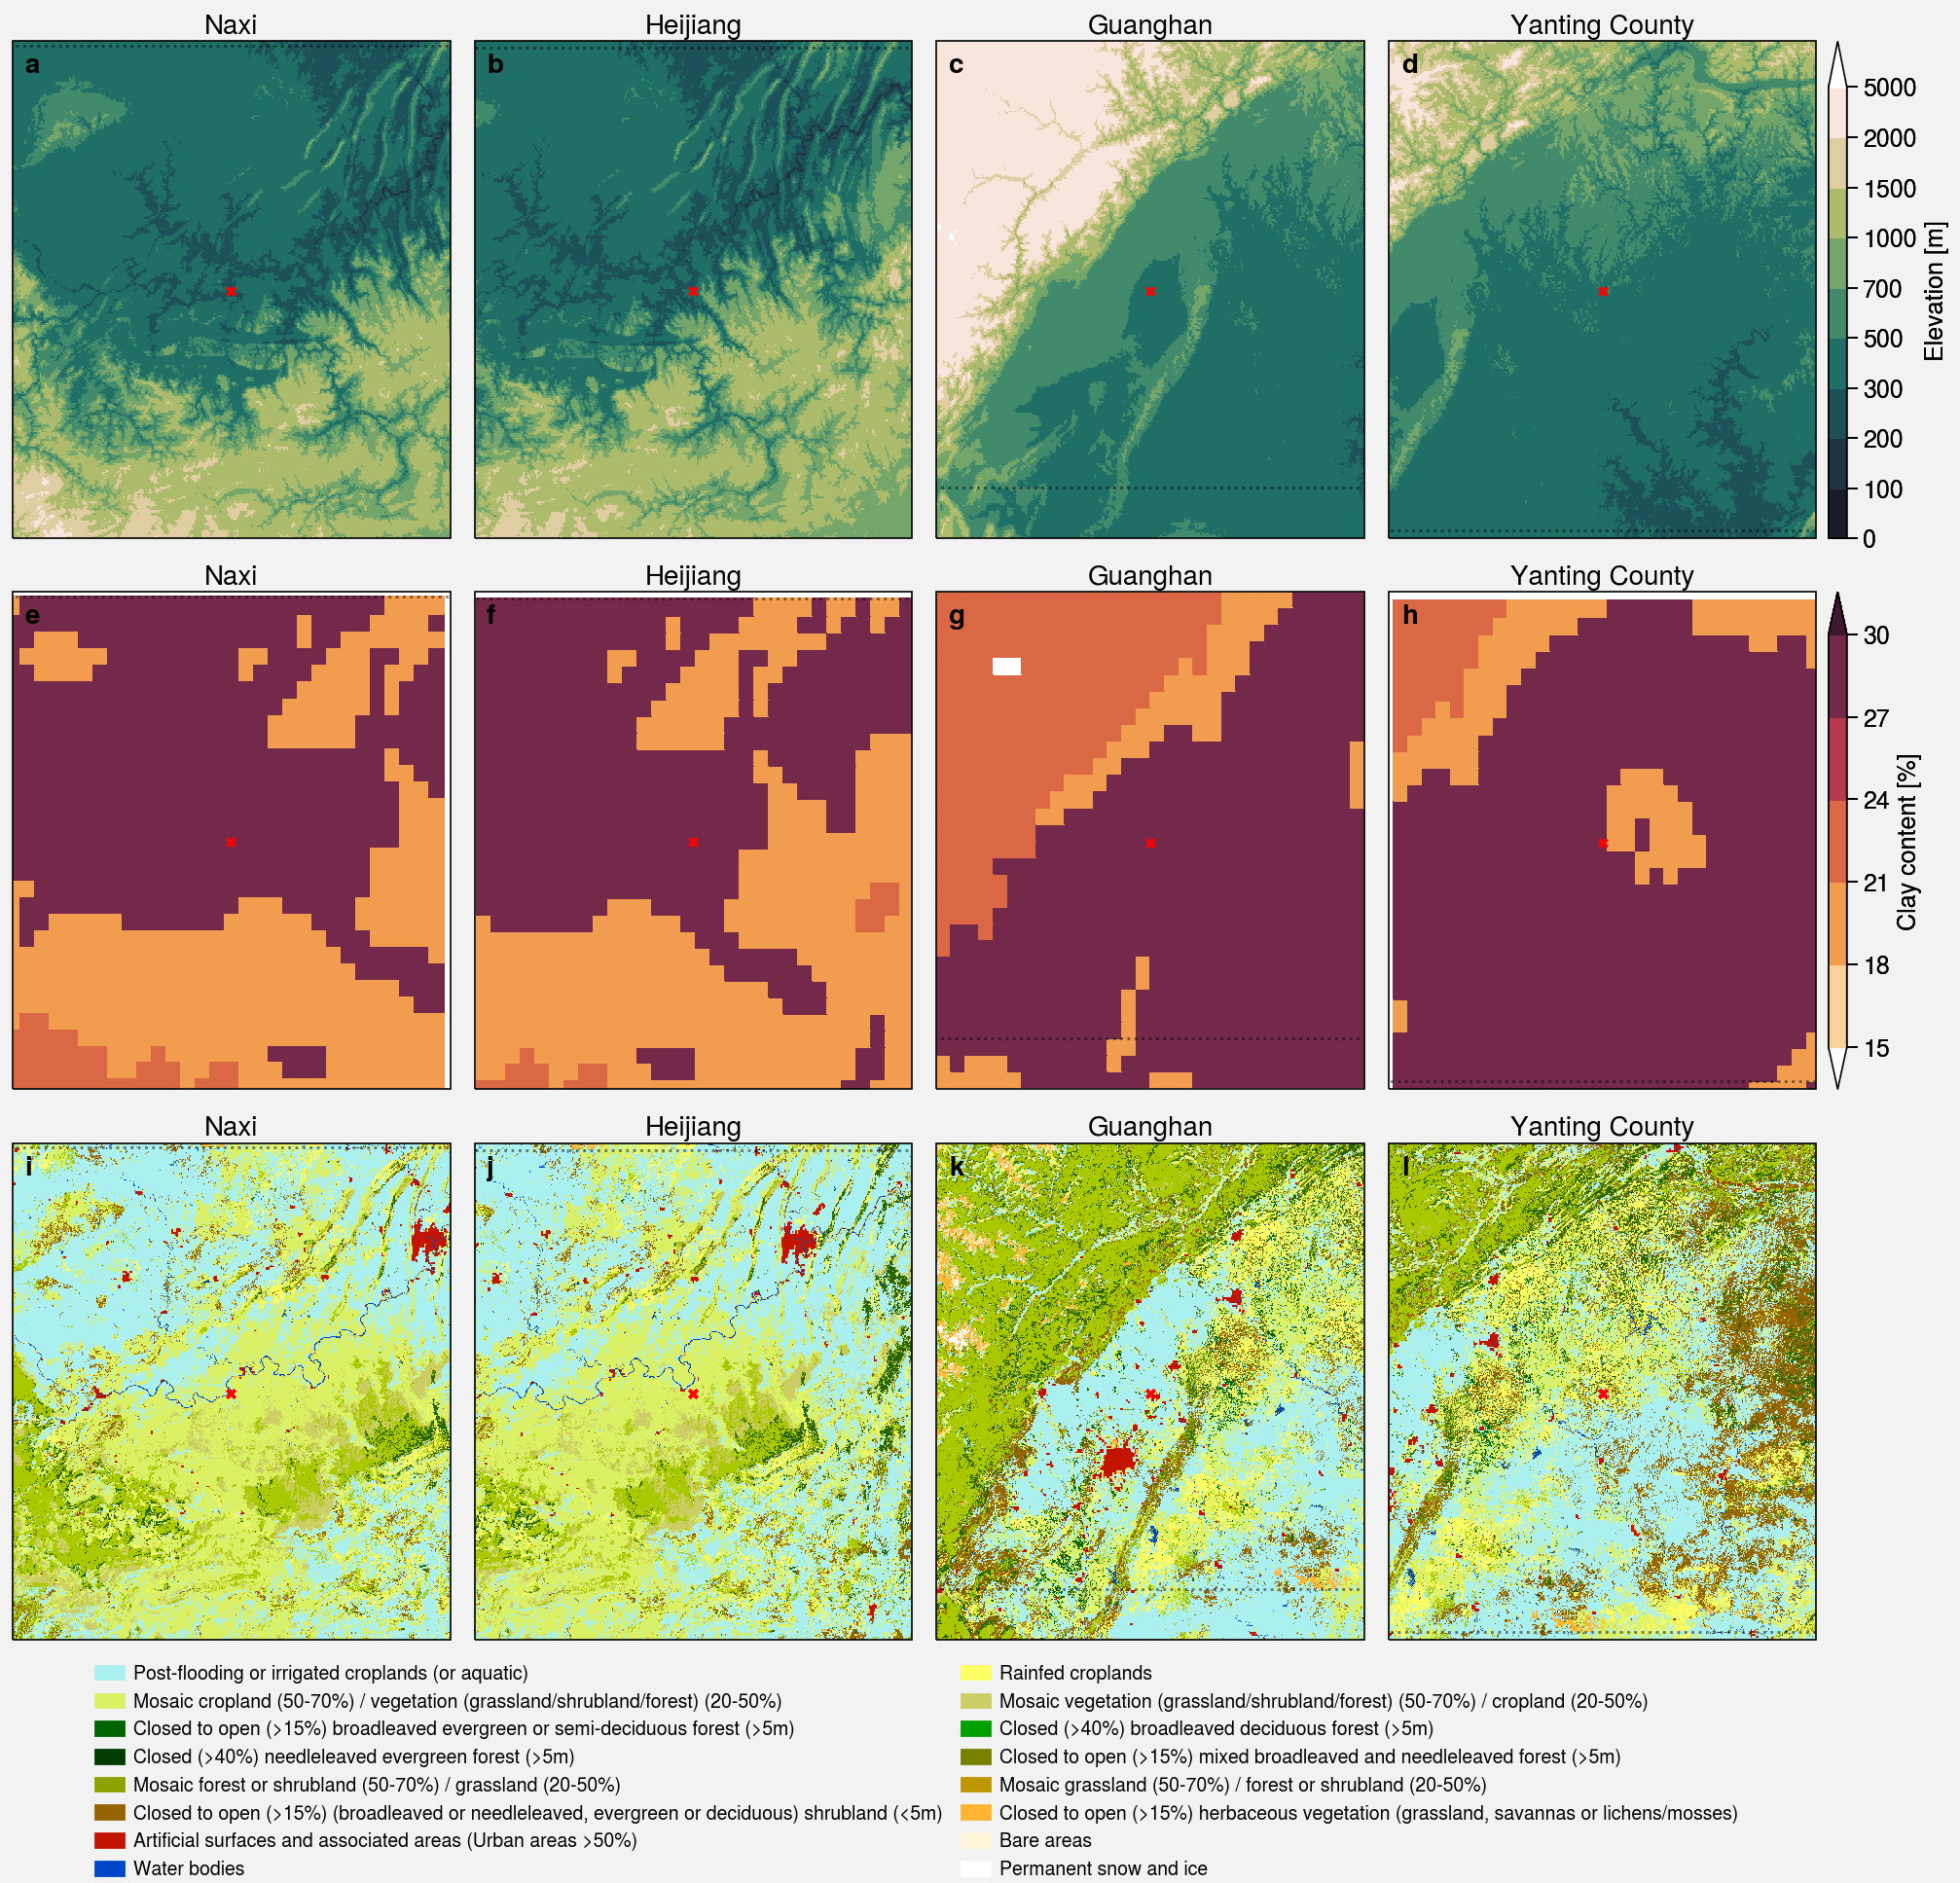

In [12]:
NCOLS = 4
NROWS = 3

f, axs = plot.subplots(ncols=NCOLS, nrows=NROWS, proj={k:'merc' for k in range(1, NCOLS*NROWS+1)})

axs.format(abc=True, abcloc='ul', abcborder=False)

regions = ['Naxi', 'Heijiang', 'Guanghan', 'Yanting County']

r = 1.25   # radius to plot around center coord / degrees


# Row A: DEM ----------------------
R = 0

VMAX = 3000
LEVELS = [0, 100, 200, 300, 500, 700, 1000, 1500, 2000, 5000]

for i, region in enumerate(regions):
    la, lo = loc[region]
    axs[i+R].pcolormesh(
        da_gtopo30.sel(lat=slice(la-r, la+r), lon=slice(lo-r, lo+r)),
        cmap='boreal_r',
        colorbar='r' if i==3 else None, 
        colorbar_kw={'label': 'Elevation [m]', 'width': '0.75em'} if i==3 else None, 
        vmin=0, vmax=VMAX, levels=LEVELS,
        extend='max',
        #linewidth=0.7, #color='gray7'
    )

# Row B: SOIL ---------------------- DUMMY
R += NCOLS 
VMIN = 15
VMAX = 30
for i, region in enumerate(regions):
    la, lo = loc[region]
    axs[i+R].pcolormesh(
        da_soil.CLPC.sel(lat=slice(la-r, la+r), lon=slice(lo-r, lo+r)),
        cmap='fire',
        colorbar='r' if i==3 else None, 
        colorbar_kw={'label': 'Clay content [%]', 'width': '0.75em'} if i==3 else None, 
        vmin=VMIN, vmax=VMAX, levels=range(VMIN, VMAX+3, 3), #levels=[0,10,20,30,40],
        extend='both',
        #linewidth=0.7, #color='gray7'
    )

    
# Row C: LU ----------------------
R += NCOLS 

LEVELS = list(lu_legend.index.values)
COLORS = list(lu_legend.hex.values)
DISCRETE = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', COLORS, len(LEVELS))
present_lu_classes = []


for i, region in enumerate(regions):
    la, lo = loc[region]
    subset = da_lu.sel(lat=slice(la-r, la+r), lon=slice(lo-r, lo+r))
    m = axs[i+R].pcolormesh(
        subset,
        cmap=DISCRETE,
        vmin=0, vmax=21, levels=LEVELS,
    )
    axs[i+R].scatter([lo], [la], color='red', marker='x')
    present_lu_classes.extend(list(np.unique(subset.values)))

# unify landuse classes from all subplots
present_lu_classes = list(set(present_lu_classes))


# ---------------------- formatting for all plots

for j in range(NROWS):
    R = j*NCOLS
    for i, region in enumerate(regions):
        la, lo = loc[region]
        axs[i+R].scatter([lo], [la], color='red', marker='x')
        axs[i+R].format(
            title=regions[i],
            lonlim=(lo-r, lo+r), latlim=(la-r, la+r),
            borders=True, coast=True, ocean=True, oceancolor='lightskyblue',
        )

        

# custom legend magic - LU classes
handles = []
for pc in list(present_lu_classes):
    row = lu_legend.loc[pc]
    
    patch = mpatches.Patch(color=row.hex, label=row.Label)
    handles.append(patch)

        
f.legend(handles=handles, frame=False, loc='b', ncols=2, fontsize=7)
f.savefig('plot_china_sites.png', facecolor='w')